In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tqdm.auto import tqdm
tqdm.pandas()


pd.set_option('display.max_columns', 50)

In [2]:
with open('Full_Dataset.pkl', 'rb') as file:
    data = pickle.load(file)

In [3]:
col2drop = ['isin', 'wkn', 'name', 'fundProvider', 'legalStructure', 'fundCurrency',
            'inceptionDate', 'ticker', 'domicileCountry', 'labels', 'Ticker_Info', 'Holdings',
            'holdings_symbols', 'holdings_names', 'holdings_percents', 'Stock_Data']

df = data.drop(columns=col2drop)
df.head()
df['quote'] = df['quote'].astype(float)

df = df.fillna(df.mean())
df.head()

,quote,ter,maxAge,cashPosition,stockPosition,bondPosition,otherPosition,preferredPosition,convertiblePosition,priceToEarnings,priceToBook,priceToSales,priceToCashflow,sector_realestate,sector_consumer_cyclical,sector_basic_materials,sector_consumer_defensive,sector_technology,sector_communication_services,sector_financial_services,sector_utilities,sector_industrials,sector_energy,sector_healthcare,Var,drawdown,avg_sharpe_ratio,beta,avg_monthly_return,volatility,RSI
0,6.68,0.0030,1,0.0042,0.9957,0.0,0.0,0.0,0.0,0.06184,0.45693,0.63720,0.09668,0.000000,0.000000,0.05850,0.227400,0.18890,0.100300,0.098100,0.000000,0.151900,0.153400,0.021400,-0.012182,-0.224168,-0.943643,0.0,0.016163,0.009947,53.540314
1,72.34,0.0030,1,0.0026,0.9974,0.0,0.0,0.0,0.0,0.06185,0.45699,0.63723,0.09669,0.000000,0.000000,0.05860,0.227400,0.18870,0.100300,0.098100,0.000000,0.152000,0.153500,0.021400,-0.011809,-0.356065,-0.803378,0.0,0.013677,0.010545,53.611734
2,10.70,0.0040,1,0.0000,0.0000,0.0,1.0,0.0,0.0,0.00000,0.00000,0.00000,0.00000,0.079179,0.096948,0.05762,0.063838,0.17264,0.060456,0.168675,0.039496,0.113065,0.041108,0.096776,-0.013404,-0.200601,-0.647148,0.0,0.030004,0.013205,65.807441
3,92.64,0.0035,1,-0.0288,1.0288,0.0,0.0,0.0,0.0,0.06283,0.79478,0.98876,0.12598,0.141400,0.059100,0.08280,0.054400,0.02380,0.000000,0.095700,0.000000,0.347500,0.144300,0.051100,-0.013861,-0.423651,-0.784502,0.0,0.005198,0.011083,46.335950
4,34.38,0.0032,1,0.0356,0.9644,0.0,0.0,0.0,0.0,0.11598,1.10211,1.36811,0.27793,0.031500,0.028400,0.10990,0.000000,0.00920,0.020300,0.416300,0.130400,0.122600,0.131300,0.000000,-0.014308,-0.484438,-0.656542,0.0,0.010611,0.012936,46.086928


# Processing of the dataset

## Extraction of the embeddings from the labels

In [4]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "yiyanghkust/finbert-tone"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, output_hidden_states=True).to(device)


def get_embedding(text):
    # Tokenize and get model outputs
    inputs = tokenizer(text, return_tensors='pt', padding=False, truncation=True, max_length=50).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    # Pooling - take the mean of token embeddings
    last_hidden_state = outputs.hidden_states[-1]
    embeddings = last_hidden_state.mean(dim=1)
    embeddings = embeddings.detach().cpu().numpy()
    return pd.Series(embeddings.flatten())


embedding_df = data['labels'].progress_apply(get_embedding)

embedding_df

  0%|          | 0/1021 [00:00<?, ?it/s]

c:\Users\thiba\OneDrive\Documents\code\ETFit\.venv\Lib\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767
0,-1.673864,0.838150,-0.754201,0.267050,1.236107,-0.578613,0.608196,0.306956,0.191781,0.798780,0.090404,-0.298927,0.338857,-0.992628,0.732582,1.487652,0.001934,1.036421,0.669500,-1.233145,-0.408093,-0.020148,0.122059,1.575999,0.225101,...,0.081083,-0.515446,0.767569,-0.430170,0.335472,0.473285,-0.179120,-0.193246,-0.775121,0.972723,-1.271222,-0.535101,0.636216,0.127387,-0.800563,1.107801,-0.272077,0.244048,0.963031,0.009196,0.289280,0.006288,0.303251,0.512392,0.205169
1,-1.673864,0.838150,-0.754201,0.267050,1.236107,-0.578613,0.608196,0.306956,0.191781,0.798780,0.090404,-0.298927,0.338857,-0.992628,0.732582,1.487652,0.001934,1.036421,0.669500,-1.233145,-0.408093,-0.020148,0.122059,1.575999,0.225101,...,0.081083,-0.515446,0.767569,-0.430170,0.335472,0.473285,-0.179120,-0.193246,-0.775121,0.972723,-1.271222,-0.535101,0.636216,0.127387,-0.800563,1.107801,-0.272077,0.244048,0.963031,0.009196,0.289280,0.006288,0.303251,0.512392,0.205169
2,-1.073503,0.369062,-0.957805,-0.059250,0.911142,-0.546690,0.122383,0.287750,-0.052159,0.668778,0.122133,-0.102141,-0.055105,-1.262777,0.811618,1.468717,-0.284447,1.251580,0.415329,-1.309739,0.037346,-0.019890,0.769479,1.369027,0.270972,...,0.521753,-0.588686,0.556159,0.040583,0.437837,0.690703,-0.657353,-0.170026,-0.950673,0.992233,-1.000732,-0.669804,0.409576,-0.230834,-0.873437,1.450425,-0.146388,0.253079,0.809261,0.341613,0.145987,0.402093,0.137212,0.122675,0.061454
3,-0.995702,0.465529,-1.007755,0.369372,1.153401,-0.732815,0.491709,-0.113516,0.177794,0.514369,0.318571,-0.538265,0.455110,-1.067960,0.627951,1.666835,-0.311075,1.346099,0.198730,-0.969911,-0.492448,0.024322,0.288126,1.521079,0.229316,...,0.276841,-0.545390,0.731972,-0.122274,0.183096,0.322055,-0.038524,0.004373,-0.619798,0.893312,-1.262428,-0.356205,0.563581,-0.006067,-1.045149,0.978778,-0.574721,0.272606,0.755672,-0.131634,0.248063,0.184148,0.097608,0.427982,0.086540
4,-1.636796,0.864313,-0.783604,0.226706,1.151697,-0.520459,0.592949,0.413433,0.194764,0.803467,0.162074,-0.334907,0.367308,-0.964490,0.699606,1.468663,-0.111681,0.982999,0.693976,-1.204773,-0.334098,0.049606,0.125799,1.544058,0.309954,...,0.115903,-0.600245,0.742636,-0.399669,0.254255,0.480318,-0.125760,-0.177906,-0.856256,0.977623,-1.419019,-0.483535,0.634350,0.052671,-0.892965,1.248784,-0.132361,0.396263,0.924517,-0.006471,0.316710,-0.041541,0.293807,0.556051,0.242319
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016,-1.111974,0.281722,-0.914338,0.247908,0.943806,-0.568186,0.195008,0.180958,0.015103,0.909760,0.219336,-0.164627,0.055517,-1.139504,0.743259,1.386136,-0.480242,1.024850,0.155980,-1.197526,0.252276,-0.074552,0.542993,1.227419,0.012656,...,0.157212,-0.742891,0.742579,-0.182418,0.527362,0.570323,-0.169035,-0.297884,-0.979114,1.343705,-1.058727,-0.531613,0.401203,-0.362736,-0.951268,0.992845,-0.219716,0.224068,0.735206,0.377181,0.165477,0.024481,0.102051,0.284976,0.220371
1017,-1.111974,0.281722,-0.914338,0.247908,0.943806,-0.568186,0.195008,0.180958,0.015103,0.909760,0.219336,-0.164627,0.055517,-1.139504,0.743259,1.386136,-0.480242,1.024850,0.155980,-1.197526,0.252276,-0.074552,0.542993,1.227419,0.012656,...,0.157212,-0.742891,0.742579,-0.182418,0.527362,0.570323,-0.169035,-0.297884,-0.979114,1.343705,-1.058727,-0.531613,0.401203,-0.362736,-0.951268,0.992845,-0.219716,0.224068,0.735206,0.377181,0.165477,0.024481,0.102051,0.284976,0.220371
1018,-1.527432,0.597885,-0.776319,-0.320791,1.354947,-0.636817,0.195067,0.611677,-0.337007,0.359255,-0.144724,-0.607273,0.120573,-0.771399,0.770068,1.261427,-1.161561,1.075619,0.171130,-1.557288,0.143387,0.122861,0.749537,1.009380,-0.067961,...,0.131153,-0.100296,0.808494,0.196454,0.775450,0.584

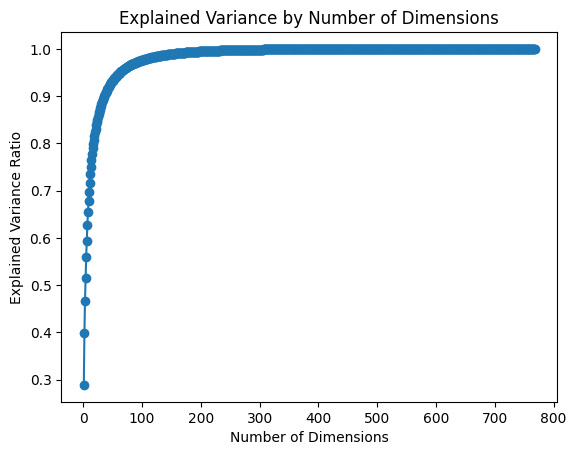

(1021, 24)

In [ ]:
X_embedding_all = embedding_df.copy()
# Apply PCA
pca = PCA()
# No normalization since the value in themselves have information, low variance means a not meaningfull feature in this case
pca.fit(X_embedding_all)


# Plot explained variance
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Dimensions')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Number of Dimensions')
plt.show()
# We reduce the dimension to avoid curse of dimensionnality

X_embeddings = PCA(0.85).fit_transform(X_embedding_all)
X_embeddings.shape

## Few tabular features
Let's find representative ETFs on which we all ask people to grade them.
<br>For this we need to not take to many features to escape from the curse of dimensionnality
<br>But also to have a good balance between sector break down and financial information

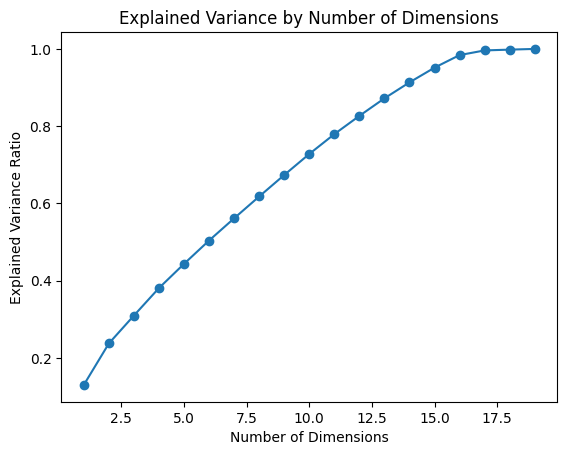

(1021, 13)

In [6]:


few_features = ['cashPosition', 'volatility', 'RSI', 'Var', 'drawdown',
                'avg_sharpe_ratio', 'beta', 'avg_monthly_return',

                'sector_realestate', 'sector_consumer_cyclical',
                'sector_basic_materials', 'sector_consumer_defensive',
                'sector_technology', 'sector_communication_services',
                'sector_financial_services', 'sector_utilities', 'sector_industrials',
                'sector_energy', 'sector_healthcare',
                ]
df_simplified = df[few_features]

std = StandardScaler()
X_std = std.fit_transform(df_simplified)

# Apply PCA
pca = PCA()
pca.fit(X_std)


# Plot explained variance
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Dimensions')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Number of Dimensions')
plt.show()
# We reduce the dimension to avoid curse of dimensionnality
X_tabular = PCA(0.85).fit_transform(X_std)
X_tabular.shape

## Combining both features

In [7]:
X = np.concatenate([X_tabular, X_embeddings], axis=1)
X.shape

(1021, 37)

# Clustering

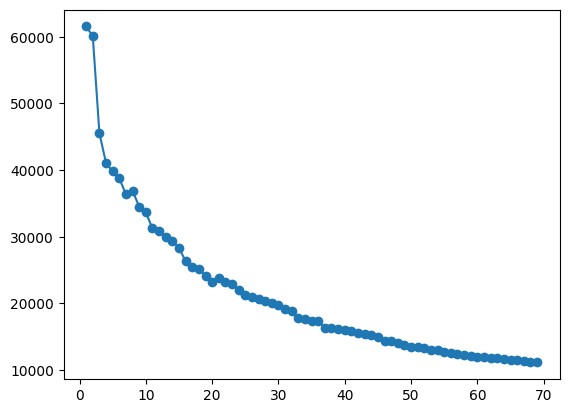

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

n_clusters_max = 70

inertia = []
for k in range(1, n_clusters_max):
    kmean = KMeans(n_clusters=k, random_state=42)
    kmean.fit(X)
    inertia.append(kmean.inertia_)

plt.plot(range(1, n_clusters_max), inertia, marker='o')

In [ ]:
from sklearn.metrics import silhouette_score
kmean = KMeans(n_clusters=20, random_state=42)
kmean.fit(X)
label = kmean.labels_
print('silhouette score is:', silhouette_score(X, label), 'which is bad')

silhouette score is: 0.19794486621031993 which is bad


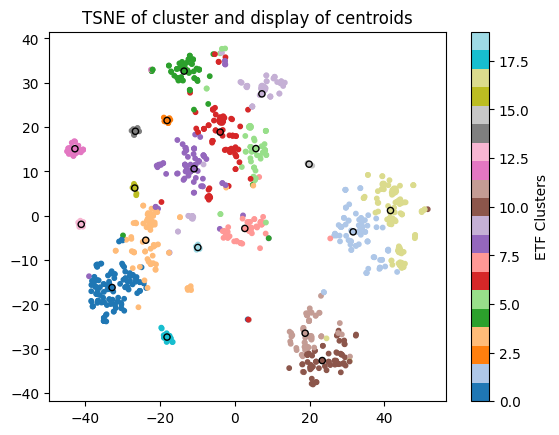

In [10]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# As we saw in the PCA these data are hard to represent well with only 2 dimensions, this partly explain the shape of the clusters
tsne = TSNE(n_components=2, random_state=15072)
temp_tsne = tsne.fit_transform(np.concatenate((X, kmean.cluster_centers_)))
X_tsne = temp_tsne[:-label.max()-1]
center = temp_tsne[-label.max()-1:]

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=label, s=10, cmap='tab20')
plt.colorbar(label="ETF Clusters")
plt.scatter(center[:, 0], center[:, 1],  c=range(center.shape[0]), s=20, edgecolors='black', cmap='tab20')
plt.title('TSNE of cluster and display of centroids')
plt.show()

In [ ]:
# Extraction the most known ETFs from each cluster

quant_traded = pd.read_csv('Data/ETFs_by_volume.csv', index_col=0)

quant_traded = quant_traded.merge(data[['quote', 'ticker']], how='inner', on='ticker')

quant_traded['weighted_average'] = quant_traded['volume'] * quant_traded['quote'].astype(float)

quant_traded = quant_traded.sort_values(by='weighted_average', ascending=False).reset_index(drop=True)[['ticker']].reset_index(names='ranking')

traded_rank = pd.merge(data, quant_traded, how='inner', on='ticker')['ranking']


n_label = label.max()
best_rank = []

for k in range(n_label):
    cluster_k = traded_rank[label == k]
    best = cluster_k.min()

    best_index = cluster_k.idxmin()

    best_ETF = quant_traded[quant_traded['ranking'] == best]['ticker'].iloc[0]

    best_rank.append([best, best_index, k, best_ETF])


best_rank = np.array(best_rank, dtype=object)

best_rank = pd.DataFrame(best_rank, columns=['ranking', 'index', 'cluster', 'ticker'])

best_rank.sort_values('ranking')

,ranking,index,cluster,ticker
5,0,352,5,IUSZ
17,1,34,17,EUN5
9,2,756,9,EUNL
6,3,318,6,EXW1
10,12,512,10,IS0F
0,15,750,0,QDVR
11,26,515,11,SXRC
1,29,363,1,2B7M
3,30,853,3,QDVE
8,37,966,8,EXV1


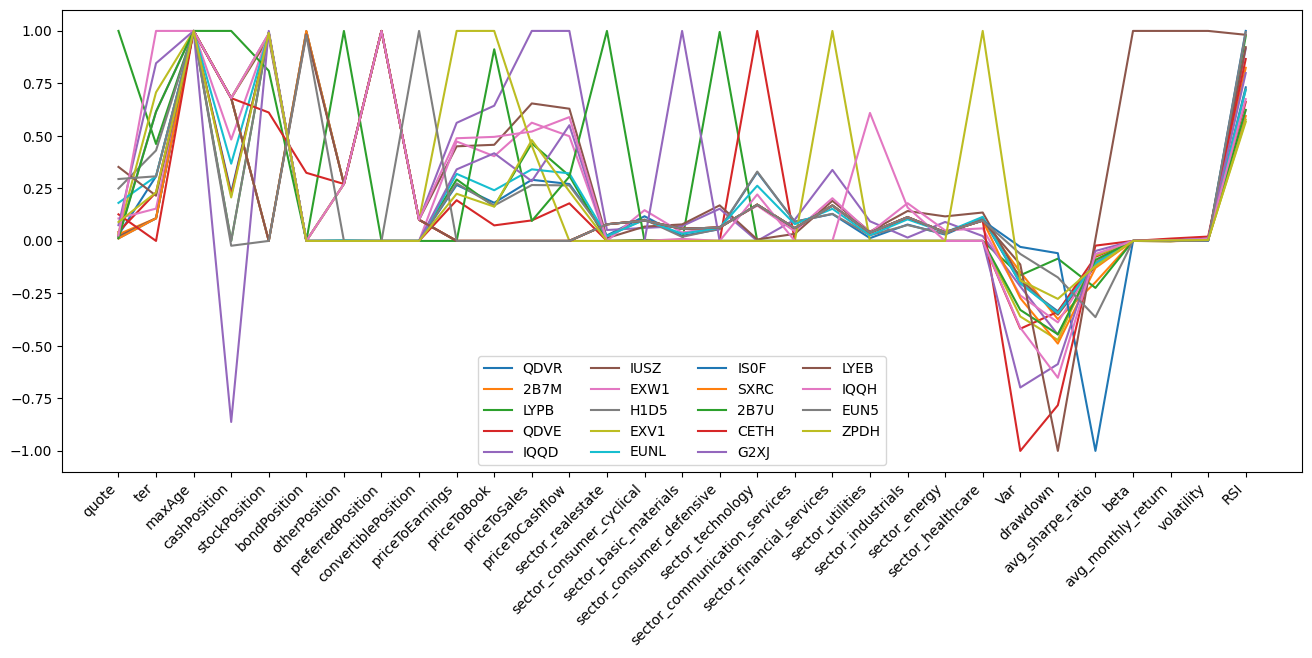

In [12]:
normalisation_term = np.abs(df.loc[best_rank['index'].astype(int)]).max(axis=0)

normalisation_term[['sector_realestate', 'sector_consumer_cyclical',
                    'sector_basic_materials', 'sector_consumer_defensive',
                    'sector_technology', 'sector_communication_services',
                    'sector_financial_services', 'sector_utilities', 'sector_industrials',
                    'sector_energy', 'sector_healthcare',]] = 1

# normalisation_term[['cashPosition', 'stockPosition', 'bondPosition', 'otherPosition',
#                     'preferredPosition', 'convertiblePosition']] = 1
normalisation_term = np.where(normalisation_term == 0, np.ones(normalisation_term.shape), normalisation_term)
plt.figure(figsize=(16, 6))
for index, ticker in best_rank[['index', 'ticker']].to_numpy():
    plt.plot(df.loc[index]/normalisation_term, label=ticker)

plt.xticks(rotation=45, ha='right')
plt.legend(loc='lower center', ncol=4)

# Creating a synthetic user preference dataset

In [13]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import cosine_similarity
import ast
labels = np.unique(data['labels'].apply(ast.literal_eval).sum())

user_labels = np.stack([np.random.choice(labels, size=(8), replace=False) for _ in range(5000)])
# user_labels = np.stack([np.random.choice(labels, size=(25), replace=False) for _ in range(10)])
user_embeddings = pd.Series([repr(row.tolist()) for row in user_labels]).progress_apply(get_embedding)
ref_ETF = embedding_df.loc[best_rank['index'].astype(int), :]
cosine_sim_matrix = cosine_similarity(np.array(user_embeddings), ref_ETF.values)
user_ratings = (cosine_sim_matrix - cosine_sim_matrix.min(axis=1, keepdims=True)) / (cosine_sim_matrix.max(axis=1, keepdims=True) - cosine_sim_matrix.min(axis=1, keepdims=True))

  0%|          | 0/5000 [00:00<?, ?it/s]

# Projection model

In [15]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Define the model class


class Encoder(nn.Module):
    def __init__(self, user_input_size, ETF_input_size, hidden_size, feature_space_size):
        super(Encoder, self).__init__()

        # Define the layers
        self.encode_user_layer = nn.Sequential(
            nn.Linear(user_input_size, user_input_size*2),
            nn.ReLU(),
            nn.Linear(user_input_size*2, user_input_size*2),
            nn.ReLU(),
            nn.Linear(user_input_size*2, feature_space_size)
        )

        self.encode_ETF_layer = nn.Sequential(
            nn.Linear(ETF_input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, feature_space_size)
        )

    def encode_ETF(self, etfs):
        x = self.encode_ETF_layer(etfs)
        return F.normalize(x, p=2, dim=-1)

    def encode_user(self, user):
        x = self.encode_user_layer(user)
        return F.normalize(x, p=2, dim=-1)

    def forward(self, users, etfs):
        return self.encode_user(users), self.encode_ETF(etfs)

## Dataset creation

In [ ]:
from torch.utils.data import DataLoader, TensorDataset, random_split

dataset = TensorDataset(torch.tensor(user_ratings))


train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)
std = StandardScaler()

# Chose which one you want
ETF_features = df.loc[best_rank['index'].astype(int), :]
ETF_features = df.values
ETF_features = X
# ETF_features = X_embedding_all.values

etfs_rated = std.fit_transform(ETF_features[best_rank['index'].astype(int), :])
etfs_rated = torch.tensor(etfs_rated, device=device, dtype=torch.float32)
all_etfs = std.transform(ETF_features)
all_etfs = torch.tensor(all_etfs, device=device, dtype=torch.float32)
all_user = torch.tensor(user_ratings, device=device, dtype=torch.float32)
label_ETF = all_user.argmax(dim=-1).cpu()

In [ ]:
# Dataset for the second model
dataset2 = TensorDataset(torch.tensor(all_etfs), torch.tensor(label))

train_size = int(0.8 * len(dataset2))
test_size = len(dataset2) - train_size
train_dataset_etfs, test_dataset_etfs = random_split(dataset2, [train_size, test_size])

train_dataloader_etfs = DataLoader(train_dataset_etfs, batch_size=32, shuffle=True)
test_dataloader_etfs = DataLoader(test_dataset_etfs, batch_size=32, shuffle=True)

C:\Users\thiba\AppData\Local\Temp\ipykernel_30680\9671830.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset2 = TensorDataset(torch.tensor(all_etfs), torch.tensor(label))


## Losses

In [17]:
import torch.nn.functional as F


def cosine_similarity_user_etf(proj_user, proj_etfs):
    n, p = proj_user.shape  # Batch size
    k = proj_etfs.size(0)

    proj_user_expanded = proj_user.unsqueeze(1).expand(n, k, p)
    proj_etfs_expanded = proj_etfs.unsqueeze(0).expand(n, k, p)

    cosine_sim = F.cosine_similarity(proj_user_expanded, proj_etfs_expanded, dim=2)  # Shape: (n, k)
    return cosine_sim


criterion = nn.CrossEntropyLoss()


def CrossEntropy_adapted(proj_user, proj_etfs, preferences):
    sim_matrix = cosine_similarity_user_etf(proj_user, proj_etfs)
    label = preferences.argmax(dim=1)
    loss = criterion(sim_matrix, label)
    return loss


def contrastive_loss_adapted(proj_etfs1, proj_etfs2, label, margin=1.0):

    euclidean_distance = F.pairwise_distance(proj_etfs1, proj_etfs2, p=2)
    positive_loss = label * torch.pow(torch.clamp(euclidean_distance - margin, min=0.0), 2)
    negative_loss = (1 - label) * torch.pow(torch.clamp(margin - euclidean_distance, min=0.0), 2)
    loss = torch.mean(positive_loss + negative_loss)
    return loss

## First model with only the ETF/user loss

In [31]:
from functools import partial

epochs = 400
lr = 5e-4
model = Encoder(user_ratings.shape[1], ETF_features.shape[1], 256, 3).to(device)

loss_fn = CrossEntropy_adapted
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

best_val_acc = 0
for epoch in range(epochs):
    model.train()
    for user_preferences in train_dataloader:
        user_preferences = user_preferences[0].to(device)
        optimizer.zero_grad()
        proj_user, proj_etfs = model(user_preferences, etfs_rated)
        loss = loss_fn(proj_user, proj_etfs, user_preferences)
        loss.backward()
        optimizer.step()

    # with torch.no_grad():
    #     sim_matrix = cosine_similarity_user_etf(proj_user, proj_etfs)
    #     accuracy = (sim_matrix.argmax(dim=1) == user_preferences.argmax(dim=1)).float().mean()
    #     print(f"Training loss = {loss.item()}, accuracy = {accuracy.item()} \t\t", end='\r')

    if (epoch % (epochs//10) == 0 or epoch % 10 == 0 or epoch == epochs-1) and True:
        model.eval()
        # Validation phase
        with torch.no_grad():
            proj_etfs = model.encode_ETF(etfs_rated)

        val_loss = 0
        val_acc = 0
        for user_preferences in test_dataloader:
            user_preferences = user_preferences[0].to(device)
            with torch.no_grad():
                proj_user = model.encode_user(user_preferences)
                sim_matrix = (cosine_similarity_user_etf(proj_user, proj_etfs) + 1) / 2
                val_acc += (sim_matrix.argmax(dim=1) == user_preferences.argmax(dim=1)).float().mean()

                val_loss += loss_fn(proj_user, proj_etfs, user_preferences)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict()
        print(f"Epoch {epoch}, Validation loss = {val_loss.item()/len(test_dataloader)}, Validation Accuracy = {val_acc.item()/len(test_dataloader)}")
model.load_state_dict(best_model_state)

Epoch 0, Validation loss = 2.147955894470215, Validation Accuracy = 0.3837890625
Epoch 10, Validation loss = 2.0862629413604736, Validation Accuracy = 0.48828125
Epoch 20, Validation loss = 2.0788049697875977, Validation Accuracy = 0.466796875
Epoch 30, Validation loss = 2.057053804397583, Validation Accuracy = 0.517578125
Epoch 40, Validation loss = 2.0431792736053467, Validation Accuracy = 0.5400390625
Epoch 50, Validation loss = 2.0398287773132324, Validation Accuracy = 0.5537109375
Epoch 60, Validation loss = 2.041637897491455, Validation Accuracy = 0.5732421875
Epoch 70, Validation loss = 2.028461456298828, Validation Accuracy = 0.5830078125
Epoch 80, Validation loss = 2.05157208442688, Validation Accuracy = 0.560546875
Epoch 90, Validation loss = 2.0205085277557373, Validation Accuracy = 0.6220703125
Epoch 100, Validation loss = 2.013674736022949, Validation Accuracy = 0.623046875
Epoch 110, Validation loss = 2.011058807373047, Validation Accuracy = 0.64453125
Epoch 120, Validati

<All keys matched successfully>

### Plots

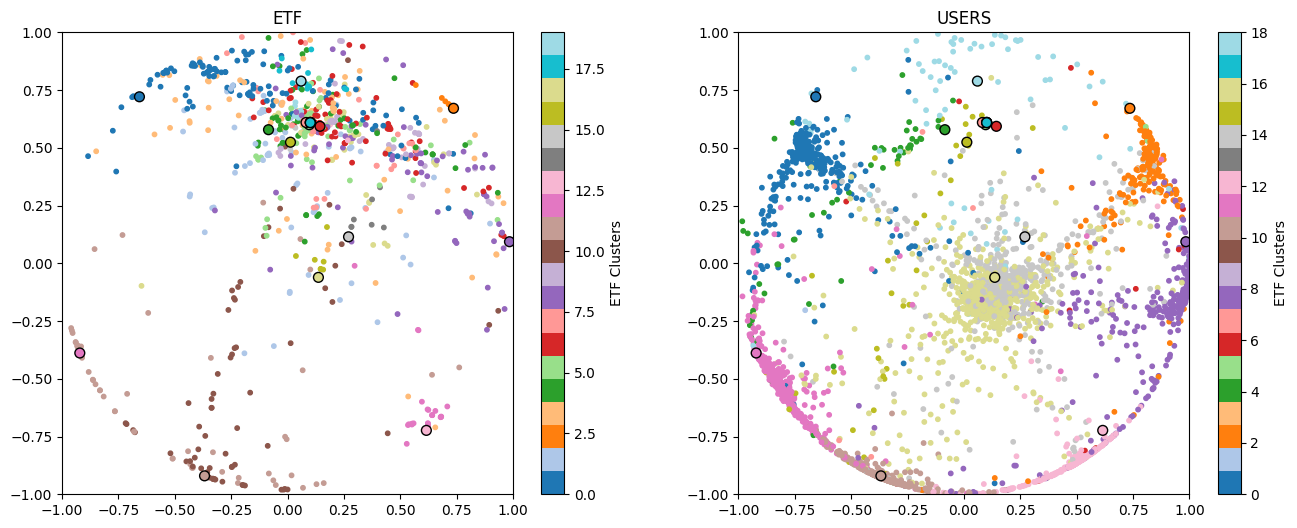

In [32]:
i, j = 0, 1

with torch.no_grad():
    all_proj_etfs = model.encode_ETF(all_etfs).cpu()
    proj_etfs = model.encode_ETF(etfs_rated).cpu()
    all_proj_user = model.encode_user(all_user).cpu()

plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.scatter(all_proj_etfs[:, i], all_proj_etfs[:, j], c=label, s=10, cmap='tab20')
plt.colorbar(label="ETF Clusters")
plt.axis((-1, 1, -1, 1))
plt.scatter(proj_etfs[:, i], proj_etfs[:, j],  c=range(proj_etfs.shape[0]), s=50, edgecolors='black', cmap='tab20')
plt.title('ETF')

plt.subplot(122)
plt.scatter(all_proj_user[:, i], all_proj_user[:, j], c=label_ETF, s=10, cmap='tab20')
plt.colorbar(label="ETF Clusters")
plt.axis((-1, 1, -1, 1))

plt.scatter(proj_etfs[:, i], proj_etfs[:, j], c=range(proj_etfs.shape[0]), s=50, edgecolors='black', cmap='tab20')
plt.title('USERS')
plt.show()

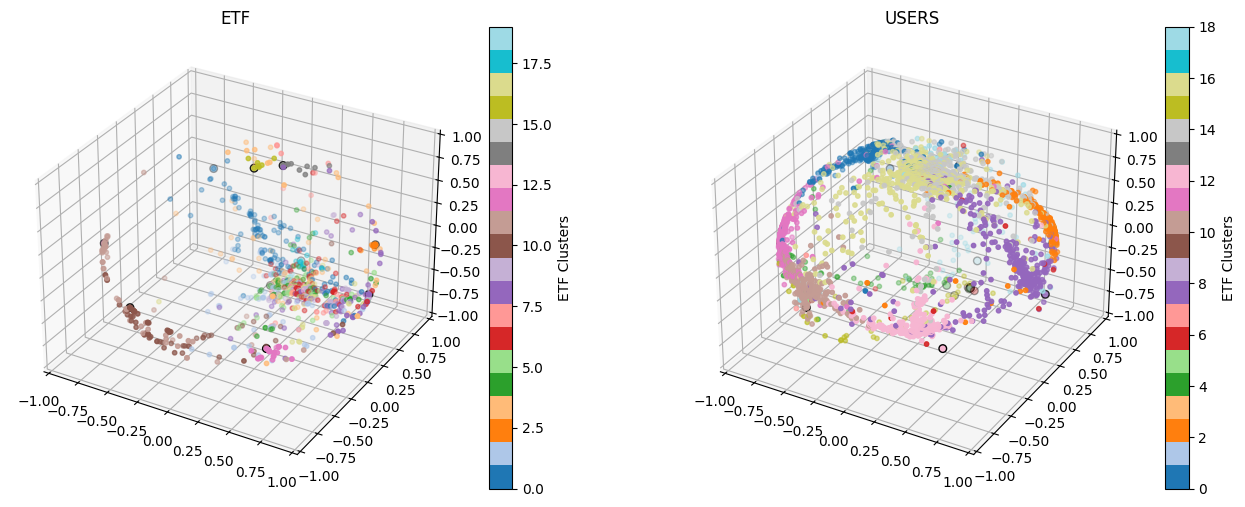

In [33]:
from mpl_toolkits.mplot3d import Axes3D

i, j, k = 0, 1, 2
fig = plt.figure(figsize=(16, 6))

# First subplot (ETF)
ax1 = fig.add_subplot(121, projection='3d')
sc1 = ax1.scatter(all_proj_etfs[:, i], all_proj_etfs[:, j], all_proj_etfs[:, k],
                  c=label, s=10, cmap='tab20')
fig.colorbar(sc1, ax=ax1, label="ETF Clusters")
ax1.scatter(proj_etfs[:, i], proj_etfs[:, j], proj_etfs[:, k],
            c=range(proj_etfs.shape[0]), s=30, edgecolors='black', cmap='tab20')
ax1.set_title('ETF')
ax1.set_xlim(-1, 1)
ax1.set_ylim(-1, 1)
ax1.set_zlim(-1, 1)

# Second subplot (USERS)
ax2 = fig.add_subplot(122, projection='3d')
sc2 = ax2.scatter(all_proj_user[:, i], all_proj_user[:, j], all_proj_user[:, k],
                  c=label_ETF, s=10, cmap='tab20')
fig.colorbar(sc2, ax=ax2, label="ETF Clusters")
ax2.scatter(proj_etfs[:, i], proj_etfs[:, j], proj_etfs[:, k],
            c=range(proj_etfs.shape[0]), s=30, edgecolors='black', cmap='tab20')
ax2.set_title('USERS')
ax2.set_xlim(-1, 1)
ax2.set_ylim(-1, 1)
ax2.set_zlim(-1, 1)
%matplotlib inline
plt.show()

## Adding a regularization term on the ETF projection

In [ ]:
from functools import partial
epochs = 600
lr = 1e-3
margin = 0.6
mu = 1e5
model = Encoder(user_ratings.shape[1], ETF_features.shape[1], 256, 3).to(device)

loss_fn1 = CrossEntropy_adapted
loss_fn2 = partial(contrastive_loss_adapted, margin=margin)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

best_val_acc = 0
etfs_iterator = iter(train_dataloader_etfs)
for epoch in range(epochs):
    model.train()
    for user_preferences in train_dataloader:
        try:
            batch1 = next(etfs_iterator)
            batch2 = next(etfs_iterator)
            if batch1[0].shape != batch2[0].shape:
                raise StopIteration
        except StopIteration:
            etfs_iterator = iter(train_dataloader_etfs)  # Restart the iterator if it reaches the end
            batch1 = next(etfs_iterator)
            batch2 = next(etfs_iterator)

        etf1, label1 = batch1[0].to(device), batch1[1].to(device)
        etf2, label2 = batch2[0].to(device), batch2[1].to(device)
        proj_etfs1 = model.encode_ETF(etf1)
        proj_etfs2 = model.encode_ETF(etf2)

        user_preferences = user_preferences[0].to(device)
        optimizer.zero_grad()
        proj_user, proj_etfs = model(user_preferences, etfs_rated)
        loss1 = loss_fn1(proj_user, proj_etfs, user_preferences)

        loss2 = loss_fn2(proj_etfs1, proj_etfs2, label=(label1 == label2).float())

        loss = loss1 + mu*loss2
        loss.backward()
        optimizer.step()

    if (epoch % (epochs//10) == 0 or epoch % 10 == 0 or epoch == epochs-1) and True:
        model.eval()
        # Validation phase
        with torch.no_grad():
            proj_etfs = model.encode_ETF(etfs_rated)

        val_loss1 = 0
        val_loss2 = 0
        val_acc = 0
        for user_preferences in test_dataloader:
            try:
                batch1 = next(etfs_iterator)
                batch2 = next(etfs_iterator)
                if batch1[0].shape != batch2[0].shape:
                    raise StopIteration
            except StopIteration:
                etfs_iterator = iter(train_dataloader_etfs)  # Restart the iterator if it reaches the end
                batch1 = next(etfs_iterator)
                batch2 = next(etfs_iterator)

            etf1, label1 = batch1[0].to(device), batch1[1].to(device)
            etf2, label2 = batch2[0].to(device), batch2[1].to(device)
            proj_etfs1 = model.encode_ETF(etf1)
            proj_etfs2 = model.encode_ETF(etf2)
            val_loss2 += loss_fn2(proj_etfs1, proj_etfs2, label=(label1 == label2).float())

            user_preferences = user_preferences[0].to(device)
            with torch.no_grad():
                proj_user = model.encode_user(user_preferences)
                sim_matrix = (cosine_similarity_user_etf(proj_user, proj_etfs) + 1) / 2
                val_acc += (sim_matrix.argmax(dim=1) == user_preferences.argmax(dim=1)).float().mean()

                val_loss1 += loss_fn1(proj_user, proj_etfs, user_preferences)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict()
        print(f"Epoch {epoch}, Validation loss1 = {val_loss1.item()/len(test_dataloader)}, Validation loss2 = {val_loss2.item()/len(test_dataloader)}, Validation Accuracy = {val_acc.item()/len(test_dataloader)}")
model.load_state_dict(best_model_state)
print(f'best val accuracy: {best_val_acc.item()/len(test_dataloader)}')

Epoch 0, Validation loss1 = 2.463803291320801, Validation loss2 = 0.009871862828731537, Validation Accuracy = 0.30859375
Epoch 10, Validation loss1 = 2.36468505859375, Validation loss2 = 0.0018237862968817353, Validation Accuracy = 0.3876953125
Epoch 20, Validation loss1 = 2.336228132247925, Validation loss2 = 0.0008208620711229742, Validation Accuracy = 0.5263671875
Epoch 30, Validation loss1 = 2.3385519981384277, Validation loss2 = 9.776264778338373e-05, Validation Accuracy = 0.5009765625
Epoch 40, Validation loss1 = 2.352564811706543, Validation loss2 = 0.00028118432965129614, Validation Accuracy = 0.5087890625
Epoch 50, Validation loss1 = 2.3328678607940674, Validation loss2 = 8.515388617524877e-05, Validation Accuracy = 0.5302734375
Epoch 60, Validation loss1 = 2.3354785442352295, Validation loss2 = 0.0004392926930449903, Validation Accuracy = 0.55078125
Epoch 70, Validation loss1 = 2.2929530143737793, Validation loss2 = 0.00013561434752773494, Validation Accuracy = 0.5771484375
E

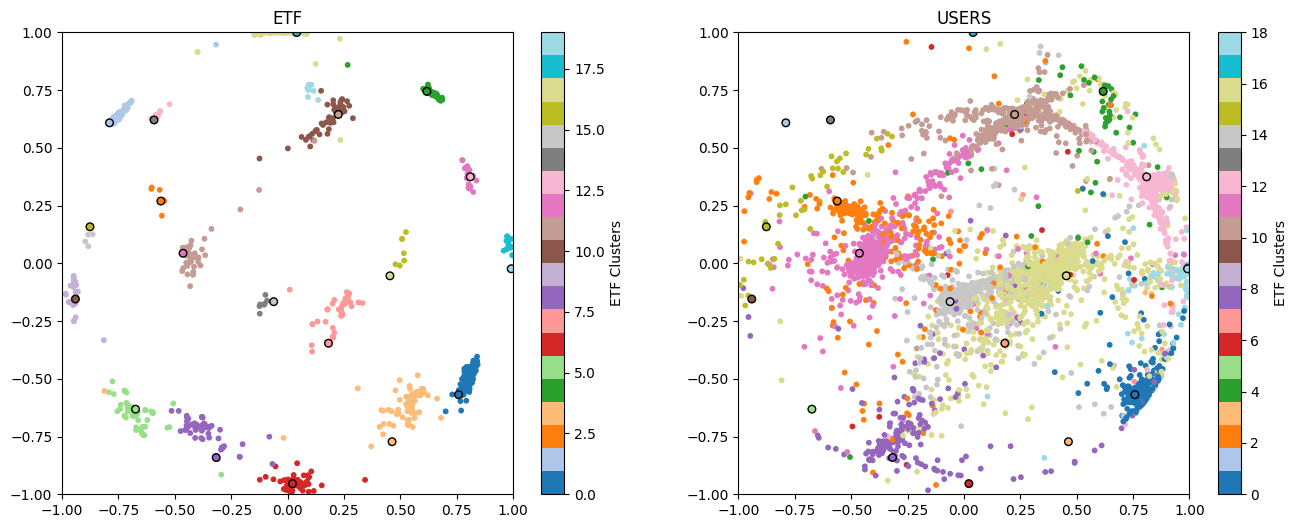

In [29]:
i, j = 0, 1
with torch.no_grad():
    all_proj_etfs = model.encode_ETF(all_etfs).cpu()
    proj_etfs = model.encode_ETF(etfs_rated).cpu()
    all_proj_user = model.encode_user(all_user).cpu()

plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.scatter(all_proj_etfs[:, i], all_proj_etfs[:, j], c=label, s=10, cmap='tab20')
plt.colorbar(label="ETF Clusters")
plt.axis((-1, 1, -1, 1))
plt.scatter(proj_etfs[:, i], proj_etfs[:, j],  c=range(proj_etfs.shape[0]), s=30, edgecolors='black', cmap='tab20')
plt.title('ETF')

plt.subplot(122)
plt.scatter(all_proj_user[:, i], all_proj_user[:, j], c=label_ETF, s=10, cmap='tab20')
plt.colorbar(label="ETF Clusters")
plt.axis((-1, 1, -1, 1))

plt.scatter(proj_etfs[:, i], proj_etfs[:, j], c=range(proj_etfs.shape[0]), s=30, edgecolors='black', cmap='tab20')
plt.title('USERS')
plt.show()

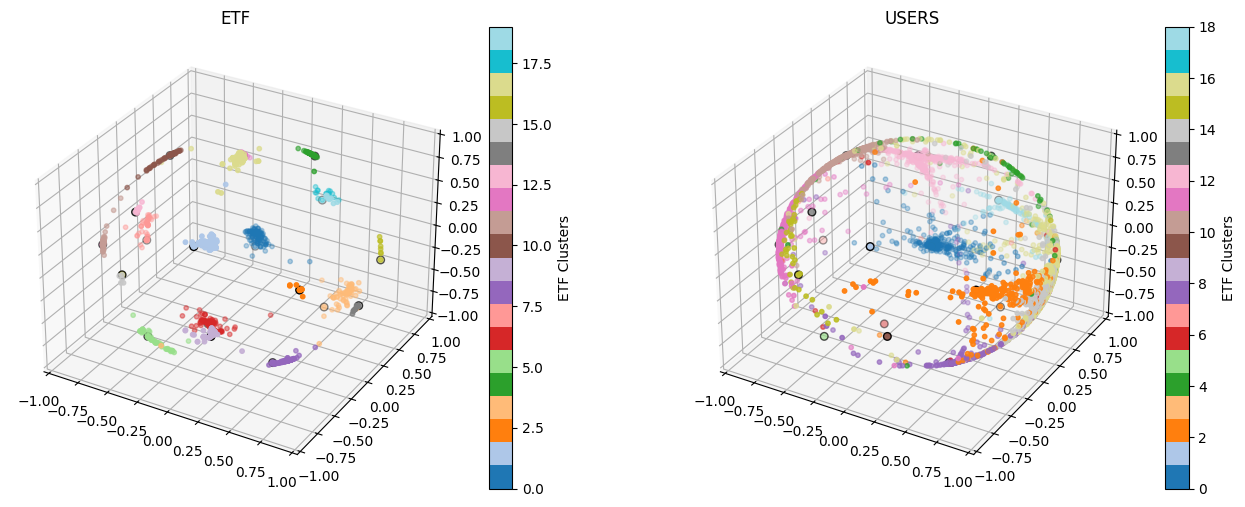

In [30]:
from mpl_toolkits.mplot3d import Axes3D

i, j, k = 2, 0, 1
fig = plt.figure(figsize=(16, 6))

# First subplot (ETF)
ax1 = fig.add_subplot(121, projection='3d')
sc1 = ax1.scatter(all_proj_etfs[:, i], all_proj_etfs[:, j], all_proj_etfs[:, k],
                  c=label, s=10, cmap='tab20')
fig.colorbar(sc1, ax=ax1, label="ETF Clusters")
ax1.scatter(proj_etfs[:, i], proj_etfs[:, j], proj_etfs[:, k],
            c=range(proj_etfs.shape[0]), s=30, edgecolors='black', cmap='tab20')
ax1.set_title('ETF')
ax1.set_xlim(-1, 1)
ax1.set_ylim(-1, 1)
ax1.set_zlim(-1, 1)

# Second subplot (USERS)
ax2 = fig.add_subplot(122, projection='3d')
sc2 = ax2.scatter(all_proj_user[:, i], all_proj_user[:, j], all_proj_user[:, k],
                  c=label_ETF, s=10, cmap='tab20')
fig.colorbar(sc2, ax=ax2, label="ETF Clusters")
ax2.scatter(proj_etfs[:, i], proj_etfs[:, j], proj_etfs[:, k],
            c=range(proj_etfs.shape[0]), s=30, edgecolors='black', cmap='tab20')
ax2.set_title('USERS')
ax2.set_xlim(-1, 1)
ax2.set_ylim(-1, 1)
ax2.set_zlim(-1, 1)
%matplotlib inline
plt.show()

## Testing with a bigger feature space

In [ ]:
from functools import partial

epochs = 600
lr = 5e-4
margin = 0.6
mu = 1e5
model = Encoder(user_ratings.shape[1], ETF_features.shape[1], 256, 12).to(device)

loss_fn1 = CrossEntropy_adapted
loss_fn2 = partial(contrastive_loss_adapted, margin=margin)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

best_val_acc = 0
etfs_iterator = iter(train_dataloader_etfs)
for epoch in range(epochs):
    model.train()
    for user_preferences in train_dataloader:
        try:
            batch1 = next(etfs_iterator)
            batch2 = next(etfs_iterator)
            if batch1[0].shape != batch2[0].shape:
                raise StopIteration
        except StopIteration:
            etfs_iterator = iter(train_dataloader_etfs)  # Restart the iterator if it reaches the end
            batch1 = next(etfs_iterator)
            batch2 = next(etfs_iterator)

        etf1, label1 = batch1[0].to(device), batch1[1].to(device)
        etf2, label2 = batch2[0].to(device), batch2[1].to(device)
        proj_etfs1 = model.encode_ETF(etf1)
        proj_etfs2 = model.encode_ETF(etf2)

        user_preferences = user_preferences[0].to(device)
        optimizer.zero_grad()
        proj_user, proj_etfs = model(user_preferences, etfs_rated)
        loss1 = loss_fn1(proj_user, proj_etfs, user_preferences)

        loss2 = loss_fn2(proj_etfs1, proj_etfs2, label=(label1 == label2).float())

        loss = loss1 + mu*loss2
        loss.backward()
        optimizer.step()

    if (epoch % (epochs//10) == 0 or epoch % 10 == 0 or epoch == epochs-1) and True:
        model.eval()
        # Validation phase
        with torch.no_grad():
            proj_etfs = model.encode_ETF(etfs_rated)

        val_loss1 = 0
        val_loss2 = 0
        val_acc = 0
        for user_preferences in test_dataloader:
            try:
                batch1 = next(etfs_iterator)
                batch2 = next(etfs_iterator)
                if batch1[0].shape != batch2[0].shape:
                    raise StopIteration
            except StopIteration:
                etfs_iterator = iter(train_dataloader_etfs)  # Restart the iterator if it reaches the end
                batch1 = next(etfs_iterator)
                batch2 = next(etfs_iterator)

            etf1, label1 = batch1[0].to(device), batch1[1].to(device)
            etf2, label2 = batch2[0].to(device), batch2[1].to(device)
            proj_etfs1 = model.encode_ETF(etf1)
            proj_etfs2 = model.encode_ETF(etf2)
            val_loss2 += loss_fn2(proj_etfs1, proj_etfs2, label=(label1 == label2).float())

            user_preferences = user_preferences[0].to(device)
            with torch.no_grad():
                proj_user = model.encode_user(user_preferences)
                sim_matrix = (cosine_similarity_user_etf(proj_user, proj_etfs) + 1) / 2
                val_acc += (sim_matrix.argmax(dim=1) == user_preferences.argmax(dim=1)).float().mean()

                val_loss1 += loss_fn1(proj_user, proj_etfs, user_preferences)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict()
        print(f"Epoch {epoch}, Validation loss1 = {val_loss1.item()/len(test_dataloader)}, Validation loss2 = {val_loss2.item()/len(test_dataloader)}, Validation Accuracy = {val_acc.item()/len(test_dataloader)}")
model.load_state_dict(best_model_state)
print(f'best val accuracy: {best_val_acc.item()/len(test_dataloader)}')

Epoch 0, Validation loss1 = 2.7015774250030518, Validation loss2 = 0.0008749537519179285, Validation Accuracy = 0.345703125
Epoch 10, Validation loss1 = 2.4869441986083984, Validation loss2 = 0.0002464581048116088, Validation Accuracy = 0.6025390625
Epoch 20, Validation loss1 = 2.4392502307891846, Validation loss2 = 4.045694367960095e-06, Validation Accuracy = 0.6611328125
Epoch 30, Validation loss1 = 2.4190924167633057, Validation loss2 = 2.7596244763117284e-05, Validation Accuracy = 0.67578125
Epoch 40, Validation loss1 = 2.4222891330718994, Validation loss2 = 2.4593991838628426e-05, Validation Accuracy = 0.7294921875
Epoch 50, Validation loss1 = 2.355360269546509, Validation loss2 = 1.1898599041160196e-05, Validation Accuracy = 0.751953125
Epoch 60, Validation loss1 = 2.373619794845581, Validation loss2 = 2.8270842449273914e-06, Validation Accuracy = 0.7490234375
Epoch 70, Validation loss1 = 2.3666329383850098, Validation loss2 = 1.1077056115027517e-05, Validation Accuracy = 0.78613